# Solve the problem leveraging ResNet152v2 architecture
In this notebook, we will use the ResNet152v2 architecture.

First, we'll try a simple **feature extraction** and after we will go on with **fine tuning**.

#Import Libraries
First of all, let's import all the libraries we will need later.

In [1]:
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import pandas as pd

# Load dataset from Google Drive
The dataset and the distractor are stored on Google Drive, we will unzip them locally to improve the performance

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!unzip -q "/content/drive/Shareddrives/MIRCV Project/test.zip" 

In [4]:
!unzip -q "/content/drive/Shareddrives/MIRCV Project/validation.zip" 

In [5]:
!unzip -q "/content/drive/Shareddrives/MIRCV Project/training.zip"

In [6]:
!unzip -q "/content/drive/Shareddrives/MIRCV Project/archive.zip" -d "/content"

In [7]:
!unzip -q '/content/drive/Shareddrives/MIRCV Project/mirflickr25k.zip' -d '/content'

# Set parameters
Let's define some global parameter for this notebook

In [8]:
fpath_test = '/content/test'
fpath_tr = '/content/training'
fpath_val = '/content/validation'


# Default values to load the dataset
BATCH_SIZE = 64
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
SEED = 42
NUM_CLASSES = 120

# Utility functions

In [9]:
from IPython.core.pylabtools import figsize
def set_seed ():
  ''' 
  set_seed is used to obtain reproducible results using keras during the development phase
  '''
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]="0"
  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(SEED)
  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(SEED)
  # The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(SEED)

def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()
  
def compile_model (model, optimizer='adam', learning_rate = 0.001):
  '''
  compile_model is used to compile the current model
  :param model: model to compile
  :param optimizer: optimizer to be used
  :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    model.compile(loss="categorical_crossentropy",
      optimizer=optimizers.Adam(learning_rate=learning_rate),
      metrics=["accuracy"])
  elif optimizer == 'rmsprop':
    model.compile(loss="categorical_crossentropy",
                  optimizer = optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
  model.summary()

def run_model (model, model_name, epochs = 50, patience = 2, monitor='val_loss'):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = model_name + '.h5'
  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  history = model.fit(ds_train,
                    epochs=epochs,
                    validation_data=ds_val,
                    callbacks=callbacks_list)

  show_training_and_validation_performance(history)

def evaluate_model (model):
  '''
  evaluate_model is used to show some statistics about the performance on the test set
  :param model: model to consider
  '''
  y_score = model.predict(ds_test)
  y_pred = np.argmax(y_score, axis=1)
  print(y_pred)
  #y_true = tf.concat([np.argmax(labels_batch, axis=1) for data_batch, labels_batch in ds_test], axis = 0)
  true_categories = tf.concat([y for x, y in ds_test], axis = 0).numpy()
  true_categories_argmax = np.argmax(true_categories, axis = 1)
  print(true_categories_argmax)
  #confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)
  #print("Confusion matrix: ")
  #print(confusion_matrix)
  print("Classification report: ")
  print(metrics.classification_report(true_categories_argmax,y_pred,digits = 4))

# Load Dataset

In [10]:
ds_test = image_dataset_from_directory(fpath_test,
                                       labels='inferred',
                                       label_mode='categorical',
                                       color_mode="rgb",
                                       batch_size=BATCH_SIZE,
                                       image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                       shuffle=False,
                                       seed=42,
                                       )

FileNotFoundError: ignored

In [ ]:
ds_train = image_dataset_from_directory(fpath_tr,
                                       labels='inferred',
                                       label_mode='categorical',
                                       color_mode="rgb",
                                       batch_size=BATCH_SIZE,
                                       image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                       shuffle=True,
                                       seed=42,
                                       )

In [ ]:
import pickle
class_names = ds_train.class_names
with open("/content/drive/Shareddrives/MIRCV Project/pickles queries/class_names.pkl", "wb") as fp:  # Pickling
            pickle.dump(class_names, fp)

In [ ]:
ds_val = image_dataset_from_directory(fpath_val,
                                       labels='inferred',
                                       label_mode='categorical',
                                       color_mode="rgb",
                                       batch_size=BATCH_SIZE,
                                       image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                       shuffle=True,
                                       seed=42,
                                       )

In [ ]:
file_paths = ds_train.file_paths
with open("training.pkl", "wb") as fp:  # Pickling
  pickle.dump(file_paths, fp)

In [ ]:
file_paths = ds_test.file_paths
with open("test.pkl", "wb") as fp:  # Pickling
  pickle.dump(file_paths, fp)

In [ ]:
file_paths = ds_val.file_paths
with open("validation.pkl", "wb") as fp:  # Pickling
  pickle.dump(file_paths, fp)

In [ ]:
ds_train = image_dataset_from_directory(fpath,
                                       labels='inferred',
                                       label_mode='categorical',
                                       color_mode="rgb",
                                       batch_size=BATCH_SIZE,
                                       image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                       shuffle=True,
                                       seed=42,
                                       validation_split=0.2,
                                       subset='training',
                                       )

val_test = image_dataset_from_directory(fpath,
                                       labels='inferred',
                                       label_mode='categorical',
                                       color_mode="rgb",
                                       batch_size=BATCH_SIZE,
                                       image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                       shuffle=True,
                                       seed=42,
                                       validation_split=0.2,
                                       subset='validation',
                                       )

val_test = val_test.shuffle(64, reshuffle_each_iteration=False, seed=45)
ds_test = val_test.skip(32)
ds_val = val_test.take(32)

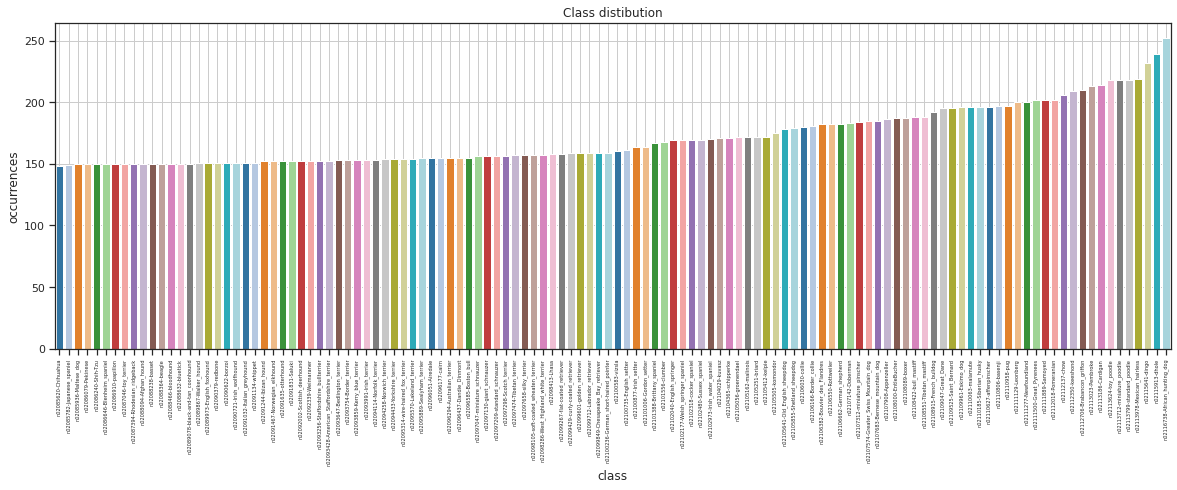

In [ ]:
import seaborn as sns
import pandas as pd
sns.set_theme(style="ticks")

labels=[]


for dir in sorted(os.listdir("/content/images/Images")):
  images = os.listdir("/content/images/Images/"+dir)
  labels.append(len(images))

classes = sorted(os.listdir("/content/images/Images"))

data = pd.DataFrame(classes, columns=['class'])
data['occurrences'] = labels
data = data.sort_values(by=['occurrences'])

fig, (ax) = plt.subplots(1, 1, figsize=(20, 6))
sns.barplot(x="class", y="occurrences", data=data, ax=ax, palette='tab20')
ax.set_title('Class distibution')
ax.set_xticklabels(labels=classes, rotation=90, fontsize=5);
ax.grid()

In [ ]:
ds_train.file_paths

['/content/images/Images/n02085620-Chihuahua/n02085620_10074.jpg',
 '/content/images/Images/n02085620-Chihuahua/n02085620_10131.jpg',
 '/content/images/Images/n02085620-Chihuahua/n02085620_10621.jpg',
 '/content/images/Images/n02085620-Chihuahua/n02085620_1073.jpg',
 '/content/images/Images/n02085620-Chihuahua/n02085620_10976.jpg',
 '/content/images/Images/n02085620-Chihuahua/n02085620_11140.jpg',
 '/content/images/Images/n02085620-Chihuahua/n02085620_11238.jpg',
 '/content/images/Images/n02085620-Chihuahua/n02085620_11258.jpg',
 '/content/images/Images/n02085620-Chihuahua/n02085620_11337.jpg',
 '/content/images/Images/n02085620-Chihuahua/n02085620_11477.jpg',
 '/content/images/Images/n02085620-Chihuahua/n02085620_1152.jpg',
 '/content/images/Images/n02085620-Chihuahua/n02085620_11696.jpg',
 '/content/images/Images/n02085620-Chihuahua/n02085620_11818.jpg',
 '/content/images/Images/n02085620-Chihuahua/n02085620_11948.jpg',
 '/content/images/Images/n02085620-Chihuahua/n02085620_1205.jpg'

In [ ]:
distractor_images = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/mirflickr25k/mirflickr',
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = BATCH_SIZE,
    seed=42,
    shuffle=False,
    labels=None,
    label_mode=None)

Found 25000 files belonging to 1 classes.


In [ ]:
distractor_fp = distractor_images.file_paths

In [ ]:
import pickle
with open("distractor.pkl", "wb") as fp:  # Pickling
  pickle.dump(distractor_fp, fp)

#Feature extraction
We will now use the convolutional base to directly extract the features. The ResNet152v2 uses a GlobalAveragePooling layer before the final classification, and the output has a dimension of 2048 values, that will be the dimension of our feature vector.

In [ ]:
conv_base = keras.applications.resnet_v2.ResNet152V2(include_top=False, weights='imagenet', input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))
conv_base.summary()

234561536/234545216 [==============================] - 2s 0us/step
Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                     

In [ ]:
feature_extractor = tf.keras.models.Sequential([
    conv_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten()
])

In [ ]:
train_features = feature_extractor.predict(ds_train, batch_size=BATCH_SIZE, verbose=1)
test_features = feature_extractor.predict(ds_test, batch_size=BATCH_SIZE, verbose=1)

33/33 [==============================] - 29s 900ms/step


In [ ]:
print(train_features.shape, test_features.shape)

(16464, 2048) (2058, 2048)


In [ ]:
np.save('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP/features_tr.npy', train_features)
np.save('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP/features_ts.npy', test_features)

In [ ]:
distractor_features = feature_extractor.predict(distractor_images, batch_size=BATCH_SIZE, verbose=1)
print(distractor_features.shape)

391/391 [==============================] - 358s 904ms/step
(25000, 2048)


In [ ]:
np.save('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP Mirko/distractor/features_dis.npy', test_features)

# MLP on top of the convnet base
First of all, we fix the bottom layers of the pretrained network and learn a new Multi-layer Perceptron (MLP) classifier on top of them

In [ ]:
conv_base.trainable = False

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1, fill_mode="nearest"),
        layers.RandomZoom(height_factor=(0.0, -0.1)),
    ]
)

## Experiment 1: Global Average Pooling

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = data_augmentation (inputs)
x = keras.applications.resnet_v2.preprocess_input(x)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D() (x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
model1 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

Epoch 1/30
258/258 [==============================] - ETA: 0s - loss: 1.5133 - accuracy: 0.6093
Epoch 1: val_loss improved from inf to 0.74466, saving model to ResNet152v2_exp1.h5
258/258 [==============================] - 366s 1s/step - loss: 1.5133 - accuracy: 0.6093 - val_loss: 0.7447 - val_accuracy: 0.7823
Epoch 2/30
258/258 [==============================] - ETA: 0s - loss: 0.8266 - accuracy: 0.7573
Epoch 2: val_loss improved from 0.74466 to 0.73426, saving model to ResNet152v2_exp1.h5
258/258 [==============================] - 338s 1s/step - loss: 0.8266 - accuracy: 0.7573 - val_loss: 0.7343 - val_accuracy: 0.7930
Epoch 3/30
258/258 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.7869
Epoch 3: val_loss did not improve from 0.73426
258/258 [==============================] - 337s 1s/step - loss: 0.6910 - accuracy: 0.7869 - val_loss: 0.7413 - val_accuracy: 0.7974
Epoch 4/30
258/258 [==============================] - ETA: 0s - loss: 0.5977 - accuracy: 0.8168
E

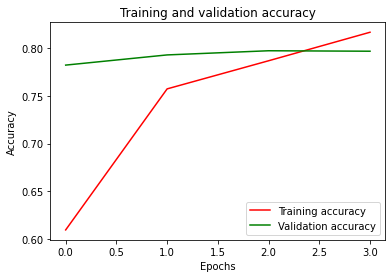

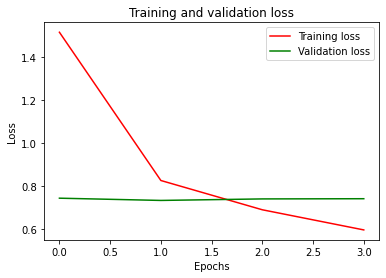

In [ ]:
run_model(model1, 'ResNet152v2_exp1', epochs = 30)

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP/ResNet152v2_exp1.h5')

In [ ]:
evaluate_model(model)

[  0   6   0 ... 119 119 119]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.7500    0.4615    0.5714        13
           1     0.8889    0.8889    0.8889        27
           2     0.9500    0.8636    0.9048        22
           3     0.9231    0.6667    0.7742        18
           4     0.6667    0.8182    0.7347        22
           5     0.7619    0.8421    0.8000        19
           6     0.7778    0.8235    0.8000        17
           7     0.7500    0.6429    0.6923        14
           8     0.7778    0.4118    0.5385        17
           9     0.9355    0.9355    0.9355        31
          10     0.7200    0.9474    0.8182        19
          11     0.7273    0.7273    0.7273        22
          12     0.8824    0.8824    0.8824        17
          13     0.8667    0.8667    0.8667        15
          14     0.8947    0.9444    0.9189        18
          15     0.6667    0.3333    0.4444        

In [ ]:
model.evaluate(ds_test)

33/33 [==============================] - 40s 1s/step - loss: 0.7806 - accuracy: 0.7775


[0.7806166410446167, 0.7774538397789001]

## Experiment 2: One dense layer with 512 neurons
We try to lower the dimension of our feature vector, adding a dense layer of 512 neurons after the global average pooling layer.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = data_augmentation (inputs)
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(512, activation='relu') (x) # feature vector
outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model2)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/15
258/258 [==============================] - ETA: 0s - loss: 1.1257 - accuracy: 0.6996
Epoch 1: val_loss improved from inf to 0.84427, saving model to ResNet152v2_exp2.h5.h5
258/258 [==============================] - 291s 1s/step - loss: 1.1257 - accuracy: 0.6996 - val_loss: 0.8443 - val_accuracy: 0.7464
Epoch 2/15
258/258 [==============================] - ETA: 0s - loss: 0.5331 - accuracy: 0.8333
Epoch 2: val_loss improved from 0.84427 to 0.74742, saving model to ResNet152v2_exp2.h5.h5
258/258 [==============================] - 274s 1s/step - loss: 0.5331 - accuracy: 0.8333 - val_loss: 0.7474 - val_accuracy: 0.7881
Epoch 3/15
258/258 [==============================] - ETA: 0s - loss: 0.3425 - accuracy: 0.8875
Epoch 3: val_loss did not improve from 0.74742
258/258 [==============================] - 272s 1s/step - loss: 0.3425 - accuracy: 0.8875 - val_loss: 0.7944 - val_accuracy: 0.7799
Epoch 4/15
258/258 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.

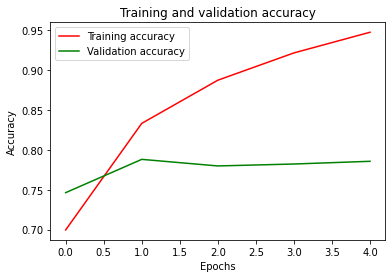

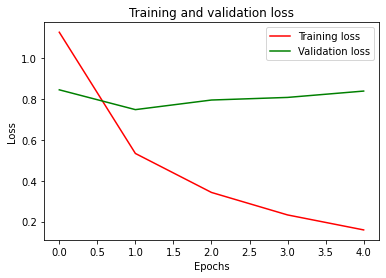

In [ ]:
run_model(model2, 'ResNet152v2_exp2.h5', epochs = 15)

In [ ]:
evaluate_model(tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP/ResNet152v2_exp2.h5.h5'))

[  7   6   0 ... 119 119 119]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.8000    0.3077    0.4444        13
           1     0.8621    0.9259    0.8929        27
           2     1.0000    0.8636    0.9268        22
           3     0.8000    0.8889    0.8421        18
           4     0.7273    0.7273    0.7273        22
           5     0.9333    0.7368    0.8235        19
           6     0.7500    0.8824    0.8108        17
           7     0.6667    0.7143    0.6897        14
           8     0.6111    0.6471    0.6286        17
           9     0.9655    0.9032    0.9333        31
          10     0.6818    0.7895    0.7317        19
          11     0.7083    0.7727    0.7391        22
          12     0.7895    0.8824    0.8333        17
          13     0.8667    0.8667    0.8667        15
          14     0.7391    0.9444    0.8293        18
          15     1.0000    0.0833    0.1538        

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP/ResNet152v2_exp2.h5.h5')
model.evaluate(ds_test)

33/33 [==============================] - 34s 926ms/step - loss: 0.8595 - accuracy: 0.7668


[0.8594944477081299, 0.7667638659477234]

## Experiment 3: One dense layer with 512 neurons and Dropoout
We try to add regularization techniques to reduce the overfitting visible in the previous experiment.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = data_augmentation (inputs)
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(512, activation='relu') (x) # feature vector
x = layers.Dropout(0.25) (x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
model3 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model3)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/15
258/258 [==============================] - ETA: 0s - loss: 1.2960 - accuracy: 0.6617
Epoch 1: val_loss improved from inf to 0.75621, saving model to ResNet152v2_exp3.h5
258/258 [==============================] - 346s 1s/step - loss: 1.2960 - accuracy: 0.6617 - val_loss: 0.7562 - val_accuracy: 0.7838
Epoch 2/15
258/258 [==============================] - ETA: 0s - loss: 0.6764 - accuracy: 0.7970
Epoch 2: val_loss improved from 0.75621 to 0.73893, saving model to ResNet152v2_exp3.h5
258/258 [==============================] - 332s 1s/step - loss: 0.6764 - accuracy: 0.7970 - val_loss: 0.7389 - val_accuracy: 0.7959
Epoch 3/15
258/258 [==============================] - ETA: 0s - loss: 0.4990 - accuracy: 0.8380
Epoch 3: val_loss improved from 0.73893 to 0.72332, saving model to ResNet152v2_exp3.h5
258/258 [==============================] - 332s 1s/step - loss: 0.4990 - accuracy: 0.8380 - val_loss: 0.7233 - val_accuracy: 0.7915
Epoch 4/15
258/258 [==============================] - ET

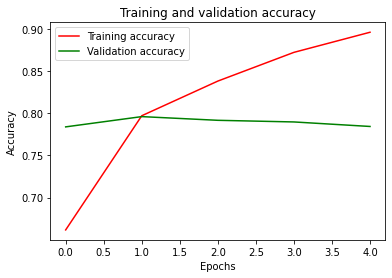

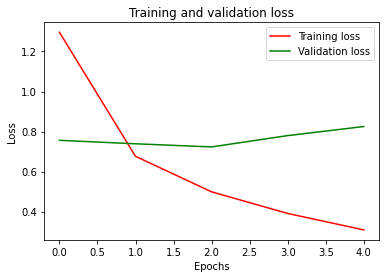

In [ ]:
run_model(model3, 'ResNet152v2_exp3', epochs = 15)

In [ ]:
evaluate_model(tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP/ResNet152v2_exp3.h5'))

[  0   6   0 ... 119 119 119]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.4615    0.4615    0.4615        13
           1     0.9583    0.8519    0.9020        27
           2     0.9474    0.8182    0.8780        22
           3     0.7778    0.7778    0.7778        18
           4     0.7368    0.6364    0.6829        22
           5     0.8182    0.9474    0.8780        19
           6     0.7273    0.9412    0.8205        17
           7     0.7333    0.7857    0.7586        14
           8     0.4412    0.8824    0.5882        17
           9     0.9643    0.8710    0.9153        31
          10     0.9375    0.7895    0.8571        19
          11     0.8500    0.7727    0.8095        22
          12     0.9231    0.7059    0.8000        17
          13     0.9167    0.7333    0.8148        15
          14     0.7391    0.9444    0.8293        18
          15     0.5455    0.5000    0.5217        

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP/ResNet152v2_exp3.h5')
model.evaluate(ds_test)

33/33 [==============================] - 40s 1s/step - loss: 0.8207 - accuracy: 0.7682


[0.8206690549850464, 0.7682215571403503]

### Feature Extraction

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP Mirko/ResNet152v2_exp3.h5')
feature_extractor = keras.Model(inputs=model.inputs, outputs=model.get_layer('dense_1').output)

In [ ]:
train_features = feature_extractor.predict(ds_train, batch_size=BATCH_SIZE, verbose=1)
test_features = feature_extractor.predict(ds_test, batch_size=BATCH_SIZE, verbose=1)
validation_features = feature_extractor.predict(ds_val, batch_size=BATCH_SIZE, verbose=1)

32/32 [==============================] - 35s 904ms/step


In [ ]:
print(train_features.shape, test_features.shape, validation_features.shape)

(16464, 512) (2068, 512) (2048, 512)


In [ ]:
np.save('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP Mirko/training/OneDense512_Dropout_feature_extraction.npy', train_features)
np.save('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP Mirko/test/OneDense512_Dropout_feature_extraction.npy', test_features)
np.save('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP Mirko/validation/OneDense512_Dropout_feature_extraction.npy', validation_features)

In [ ]:
distractor_features = feature_extractor.predict(distractor_images, batch_size=BATCH_SIZE, verbose=1)
print(distractor_features.shape)

391/391 [==============================] - 358s 903ms/step
(25000, 512)


In [ ]:
np.save('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP Mirko/distractor/OneDense512_Dropout_feature_extraction.npy', distractor_features)

# Fine tuning
We can now try fine-tuning to adapt the network to our dataset

## Unfreeze the 5-th block
Firstly, we try to unfreeze only the layers of the 5-th block of the ResNet architecture.

### Experiment 1: Global Average Pooling

In [ ]:
model1 = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP/ResNet152v2_exp1.h5')

set_trainable = False
# set the 5-th block as trainable
for layer in model1.get_layer('resnet152v2').layers:
    if layer.name == 'conv5_block2_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model1, learning_rate=1e-5)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

Epoch 1/15
258/258 [==============================] - ETA: 0s - loss: 0.9569 - accuracy: 0.7686
Epoch 1: val_loss improved from inf to 0.69997, saving model to FineTuning_EXP1.h5
258/258 [==============================] - 378s 1s/step - loss: 0.9569 - accuracy: 0.7686 - val_loss: 0.7000 - val_accuracy: 0.7998
Epoch 2/15
258/258 [==============================] - ETA: 0s - loss: 0.7644 - accuracy: 0.8055
Epoch 2: val_loss improved from 0.69997 to 0.68708, saving model to FineTuning_EXP1.h5
258/258 [==============================] - 362s 1s/step - loss: 0.7644 - accuracy: 0.8055 - val_loss: 0.6871 - val_accuracy: 0.8081
Epoch 3/15
258/258 [==============================] - ETA: 0s - loss: 0.6850 - accuracy: 0.8188
Epoch 3: val_loss improved from 0.68708 to 0.66977, saving model to FineTuning_EXP1.h5
258/258 [==============================] - 363s 1s/step - loss: 0.6850 - accuracy: 0.8188 - val_loss: 0.6698 - val_accuracy: 0.8086
Epoch 4/15
258/258 [==============================] - ETA: 

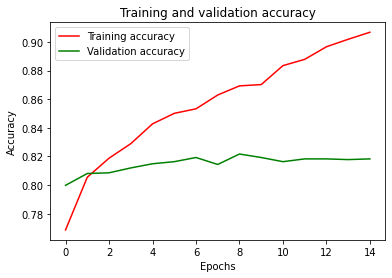

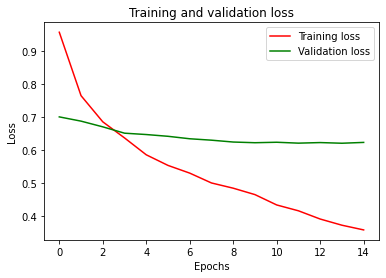

In [ ]:
run_model(model1, 'FineTuning_EXP1', epochs = 15)

In [ ]:
evaluate_model(tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP/FineTuning_EXP1.h5'))

[  0   0   0 ... 119 119 119]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.8182    0.6923    0.7500        13
           1     0.9231    0.8889    0.9057        27
           2     0.9130    0.9545    0.9333        22
           3     0.9412    0.8889    0.9143        18
           4     0.7619    0.7273    0.7442        22
           5     0.8000    0.8421    0.8205        19
           6     0.7895    0.8824    0.8333        17
           7     0.7333    0.7857    0.7586        14
           8     0.7059    0.7059    0.7059        17
           9     0.9677    0.9677    0.9677        31
          10     0.8947    0.8947    0.8947        19
          11     0.8421    0.7273    0.7805        22
          12     0.8333    0.8824    0.8571        17
          13     0.7368    0.9333    0.8235        15
          14     1.0000    0.8333    0.9091        18
          15     0.5833    0.5833    0.5833        

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP/FineTuning_EXP1.h5')
model.evaluate(ds_test)

33/33 [==============================] - 41s 1s/step - loss: 0.6497 - accuracy: 0.8086


[0.6497249007225037, 0.8085519671440125]

#### Feature Extraction

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP Mirko/ResNet152v2_exp1.h5')
intermediate_layer_model = keras.Model(inputs=model.inputs, outputs=model.get_layer('global_average_pooling2d_1').input)
feature_extractor = tf.keras.models.Sequential([
    intermediate_layer_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten()
])

In [ ]:
train_features = feature_extractor.predict(ds_train, batch_size=BATCH_SIZE, verbose=1)
test_features = feature_extractor.predict(ds_test, batch_size=BATCH_SIZE, verbose=1)
validation_features = feature_extractor.predict(ds_val, batch_size=BATCH_SIZE, verbose=1)

32/32 [==============================] - 35s 903ms/step


In [ ]:
print(train_features.shape, test_features.shape, validation_features.shape)

(16464, 2048) (2068, 2048) (2048, 2048)


In [ ]:
np.save('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP Mirko/training/global_average_pooling_fine_tuning.npy', train_features)
np.save('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP Mirko/test/global_average_pooling_fine_tuning.npy', test_features)
np.save('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP Mirko/validation/global_average_pooling_fine_tuning.npy', validation_features)

In [ ]:
distractor_features = feature_extractor.predict(distractor_images, batch_size=BATCH_SIZE, verbose=1)
print(distractor_features.shape)

391/391 [==============================] - 360s 904ms/step
(25000, 2048)


In [ ]:
np.save('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP Mirko/distractor/global_average_pooling_fine_tuning.npy', distractor_features)

### Experiment 2: One dense layer with 512 neurons

In [ ]:
model2 = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP/ResNet152v2_exp2.h5')

set_trainable = False
# set the 5-th block as trainable
for layer in model2.get_layer('resnet152v2').layers:
    if layer.name == 'conv5_block2_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model2, learning_rate=1e-5)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/15
258/258 [==============================] - ETA: 0s - loss: 0.6222 - accuracy: 0.8627
Epoch 1: val_loss improved from inf to 0.65615, saving model to FineTuning_EXP2.h5
258/258 [==============================] - 320s 1s/step - loss: 0.6222 - accuracy: 0.8627 - val_loss: 0.6562 - val_accuracy: 0.8022
Epoch 2/15
258/258 [==============================] - ETA: 0s - loss: 0.3232 - accuracy: 0.9303
Epoch 2: val_loss improved from 0.65615 to 0.64511, saving model to FineTuning_EXP2.h5
258/258 [==============================] - 307s 1s/step - loss: 0.3232 - accuracy: 0.9303 - val_loss: 0.6451 - val_accuracy: 0.8008
Epoch 3/15
258/258 [==============================] - ETA: 0s - loss: 0.2130 - accuracy: 0.9600
Epoch 3: val_loss improved from 0.64511 to 0.63926, saving model to FineTuning_EXP2.h5
258/258 [==============================] - 307s 1s/step - loss: 0.2130 - accuracy: 0.9600 - val_loss: 0.6393 - val_accuracy: 0.8037
Epoch 4/15
258/258 [==============================] - ETA: 

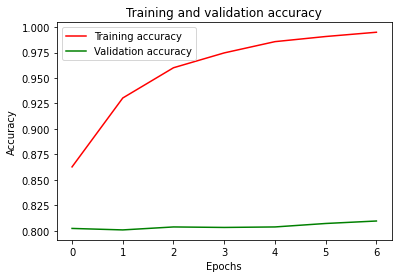

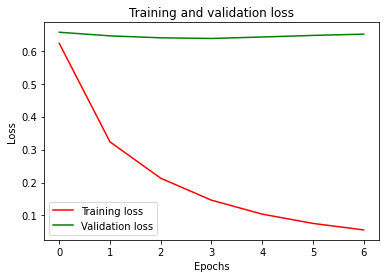

In [ ]:
run_model(model2, 'FineTuning_EXP2', epochs = 15)

In [ ]:
evaluate_model(tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP/FineTuning_EXP2.h5'))

[  0   6   0 ... 119 119 119]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.5385    0.5385    0.5385        13
           1     0.8929    0.9259    0.9091        27
           2     0.8800    1.0000    0.9362        22
           3     0.7619    0.8889    0.8205        18
           4     0.7500    0.6818    0.7143        22
           5     0.8889    0.8421    0.8649        19
           6     0.7500    0.8824    0.8108        17
           7     0.6875    0.7857    0.7333        14
           8     0.5882    0.5882    0.5882        17
           9     0.9375    0.9677    0.9524        31
          10     0.8750    0.7368    0.8000        19
          11     0.7083    0.7727    0.7391        22
          12     0.7778    0.8235    0.8000        17
          13     0.7500    0.8000    0.7742        15
          14     0.8500    0.9444    0.8947        18
          15     0.6667    0.5000    0.5714        

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP/FineTuning_EXP2.h5')
model.evaluate(ds_test)

33/33 [==============================] - 33s 924ms/step - loss: 0.7220 - accuracy: 0.7920


[0.721954882144928, 0.7920311093330383]

#### Feature Extraction

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP Mirko/FineTuning_EXP2.h5')
feature_extractor = keras.Model(inputs=model.inputs, outputs=model.get_layer('dense').output)
feature_extractor.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
train_features = feature_extractor.predict(ds_train, batch_size=BATCH_SIZE, verbose=1)
test_features = feature_extractor.predict(ds_test, batch_size=BATCH_SIZE, verbose=1)
validation_features = feature_extractor.predict(ds_val, batch_size=BATCH_SIZE, verbose=1)

32/32 [==============================] - 35s 904ms/step


In [ ]:
print(train_features.shape, test_features.shape, validation_features.shape)

(16464, 512) (2068, 512) (2048, 512)


In [ ]:
np.save('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP Mirko/training/OneDense512_fine_tuning.npy', train_features)
np.save('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP Mirko/test/OneDense512_fine_tuning.npy', test_features)
np.save('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP Mirko/validation/OneDense512_fine_tuning.npy', validation_features)

In [ ]:
distractor_features = feature_extractor.predict(distractor_images, batch_size=BATCH_SIZE, verbose=1)
print(distractor_features.shape)

391/391 [==============================] - 358s 903ms/step
(25000, 512)


In [ ]:
np.save('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP Mirko/distractor/OneDense512_fine_tuning.npy', distractor_features)

### Experiment 3: One dense layer with 512 neurons and Dropout

In [ ]:
model3 = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP/ResNet152v2_exp3.h5')

set_trainable = False
# set the 5-th block as trainable
for layer in model3.get_layer('resnet152v2').layers:
    if layer.name == 'conv5_block2_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model3, learning_rate=1e-5)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/15
258/258 [==============================] - ETA: 0s - loss: 0.6478 - accuracy: 0.8474
Epoch 1: val_loss improved from inf to 0.67615, saving model to FineTuning_EXP3.h5
258/258 [==============================] - 370s 1s/step - loss: 0.6478 - accuracy: 0.8474 - val_loss: 0.6762 - val_accuracy: 0.8008
Epoch 2/15
258/258 [==============================] - ETA: 0s - loss: 0.4103 - accuracy: 0.8924
Epoch 2: val_loss improved from 0.67615 to 0.65472, saving model to FineTuning_EXP3.h5
258/258 [==============================] - 356s 1s/step - loss: 0.4103 - accuracy: 0.8924 - val_loss: 0.6547 - val_accuracy: 0.8110
Epoch 3/15
258/258 [==============================] - ETA: 0s - loss: 0.3133 - accuracy: 0.9153
Epoch 3: val_loss improved from 0.65472 to 0.64614, saving model to FineTuning_EXP3.h5
258/258 [==============================] - 356s 1s/step - loss: 0.3133 - accuracy: 0.9153 - val_loss: 0.6461 - val_accuracy: 0.8095
Epoch 4/15
258/258 [==============================] - ETA: 

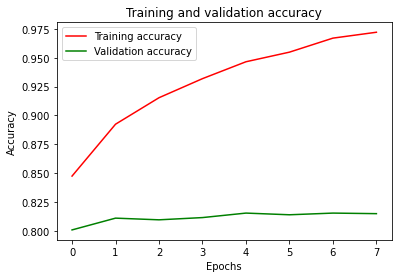

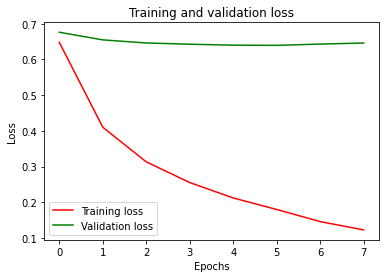

In [ ]:
run_model(model3, 'FineTuning_EXP3', epochs = 15)

In [ ]:
evaluate_model(tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP/FineTuning_EXP3.h5'))

[  0   0   0 ... 119 119 119]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.5333    0.6154    0.5714        13
           1     0.8929    0.9259    0.9091        27
           2     0.9545    0.9545    0.9545        22
           3     1.0000    0.7778    0.8750        18
           4     0.7273    0.7273    0.7273        22
           5     0.8500    0.8947    0.8718        19
           6     0.7500    0.8824    0.8108        17
           7     0.7333    0.7857    0.7586        14
           8     0.7059    0.7059    0.7059        17
           9     0.9667    0.9355    0.9508        31
          10     0.8667    0.6842    0.7647        19
          11     0.6538    0.7727    0.7083        22
          12     0.8824    0.8824    0.8824        17
          13     0.7333    0.7333    0.7333        15
          14     0.8421    0.8889    0.8649        18
          15     0.7500    0.5000    0.6000        

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP/FineTuning_EXP3.h5')
model.evaluate(ds_test)

33/33 [==============================] - 40s 1s/step - loss: 0.7123 - accuracy: 0.7954


[0.7123181223869324, 0.795432448387146]

#### Feature Extraction

In [ ]:
import numpy
fpath = "/content/drive/Shareddrives/MIRCV Project/others/test/cane_di_armando.jpg"
savepath = "/content/drive/Shareddrives/MIRCV Project/others/test/cane_di_armando.npy"
image = tf.keras.preprocessing.image.load_img(fpath, target_size=(224,224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = numpy.array([input_arr])
img_features = feature_extractor.predict(input_arr, verbose=1)
print(img_features.shape)
np.save(savepath, img_features)

1/1 [==============================] - 0s 54ms/step
(1, 512)


In [ ]:
pastori_tedeschi = image_dataset_from_directory('/content/mirflickr25k/mirflickr/im10001.jpg',
                                       color_mode="rgb",
                                       #batch_size=BATCH_SIZE,
                                       image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                       shuffle=False,
                                       seed=42,
                                       labels=None,
                                       label_mode=None
                                       )

Found 0 files belonging to 1 classes.


ValueError: ignored

In [ ]:
pastori_tedeschi_fp = pastori_tedeschi.file_paths
with open("pastori_tedeschi.pkl", "wb") as fp:  # Pickling
  pickle.dump(pastori_tedeschi_fp, fp)

In [ ]:
pastori_tedeschi_features = feature_extractor.predict(pastori_tedeschi, batch_size=BATCH_SIZE, verbose=1)
np.save('/content/drive/Shareddrives/MIRCV Project/others/features/pastori_tedeschi1.npy', pastori_tedeschi_features)

1/1 [==============================] - 0s 150ms/step


In [ ]:
print(pastori_tedeschi_features.shape)

(14, 512)


In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP Mirko/ResNet152v2_exp3.h5')
feature_extractor = keras.Model(inputs=model.inputs, outputs=model.get_layer('dense_1').output)

In [ ]:
train_features = feature_extractor.predict(ds_train, batch_size=BATCH_SIZE, verbose=1)
test_features = feature_extractor.predict(ds_test, batch_size=BATCH_SIZE, verbose=1)
validation_features = feature_extractor.predict(ds_val, batch_size=BATCH_SIZE, verbose=1)

33/33 [==============================] - 27s 851ms/step


In [ ]:
print(train_features.shape, test_features.shape, validation_features.shape)

(16464, 512) (2058, 512) (2058, 512)


In [ ]:
np.save('/content/drive/Shareddrives/MIRCV Project/others/features/training.npy', train_features)
np.save('/content/drive/Shareddrives/MIRCV Project/others/features/test.npy', test_features)
np.save('/content/drive/Shareddrives/MIRCV Project/others/features/validation.npy', validation_features)

In [ ]:
distractor_features = feature_extractor.predict(distractor_images, batch_size=BATCH_SIZE, verbose=1)
print(distractor_features.shape)

391/391 [==============================] - 337s 857ms/step
(25000, 512)


In [ ]:
np.save('/content/drive/Shareddrives/MIRCV Project/others/features/distractor.npy', distractor_features)

## Unfreeze also the 4-th block
We try also to unfreeze the 4-th block to see if there are improvement in the performances.

### Experiment 4: GlobalAveragePooling

In [ ]:
model4 = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet152v2/EXP Mirko/ResNet152v2_exp1.h5')

set_trainable = False
# set from the 4-th block as trainable
for layer in model4.get_layer('resnet152v2').layers:
  if layer.name == 'conv4_block1_1_conv': 
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
compile_model(model4, learning_rate=1e-5)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                             

Epoch 1/10
258/258 [==============================] - ETA: 0s - loss: 4.2249 - accuracy: 0.0930
Epoch 1: val_loss improved from inf to 2.81425, saving model to GlobalAveragePooling_fine_tuning_4th.h5
258/258 [==============================] - 660s 3s/step - loss: 4.2249 - accuracy: 0.0930 - val_loss: 2.8143 - val_accuracy: 0.5112
Epoch 2/10
258/258 [==============================] - ETA: 0s - loss: 3.6544 - accuracy: 0.1843
Epoch 2: val_loss improved from 2.81425 to 2.72545, saving model to GlobalAveragePooling_fine_tuning_4th.h5
258/258 [==============================] - 654s 3s/step - loss: 3.6544 - accuracy: 0.1843 - val_loss: 2.7255 - val_accuracy: 0.5092
Epoch 3/10
258/258 [==============================] - ETA: 0s - loss: 3.1574 - accuracy: 0.3113
Epoch 3: val_loss improved from 2.72545 to 2.58107, saving model to GlobalAveragePooling_fine_tuning_4th.h5
258/258 [==============================] - 653s 3s/step - loss: 3.1574 - accuracy: 0.3113 - val_loss: 2.5811 - val_accuracy: 0.5

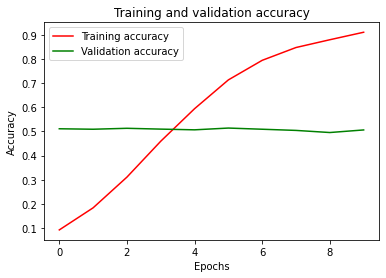

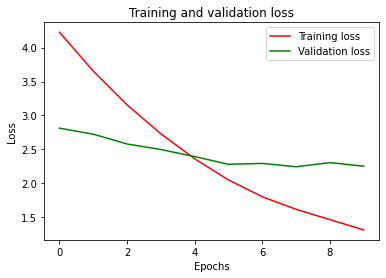

In [ ]:
run_model(model4, 'GlobalAveragePooling_fine_tuning_4th', epochs = 10, patience = 2)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/GlobalAveragePooling_fine_tuning_4th.h5'))

Confusion matrix: 
tf.Tensor(
[[5 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 5]], shape=(325, 325), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         5
           1     1.0000    0.8000    0.8889         5
           2     1.0000    1.0000    1.0000         5
           3     1.0000    1.0000    1.0000         5
           4     1.0000    1.0000    1.0000         5
           5     1.0000    1.0000    1.0000         5
           6     1.0000    1.0000    1.0000         5
           7     0.8333    1.0000    0.9091         5
           8     1.0000    1.0000    1.0000         5
           9     1.0000    1.0000    1.0000         5
          10     1.0000    1.0000    1.0000         5
          11     1.0000    1.0000    1.0000         5
          12     1.0000    1.0000    1.0000         5
          13     1.0000    1.0000    

In [ ]:
model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/GlobalAveragePooling_fine_tuning_4th.h5')
model.evaluate(test_dataset)

13/13 [==============================] - 31s 2s/step - loss: 0.0703 - accuracy: 0.9828


[0.07034151256084442, 0.982769250869751]

#### Feature extraction

In [ ]:
model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/GlobalAveragePooling_fine_tuning_4th.h5')
intermediate_layer_model = keras.Model(inputs=model.inputs, outputs=model.get_layer('global_average_pooling2d').input)
feature_extractor = tf.keras.models.Sequential([
    intermediate_layer_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten()
])

In [ ]:
train_features = feature_extractor.predict(load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, shuffle=False), batch_size=BATCH_SIZE, verbose=1)
test_features = feature_extractor.predict(load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, shuffle=False), batch_size=BATCH_SIZE, verbose=1)
validation_features = feature_extractor.predict(load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, shuffle=False), batch_size=BATCH_SIZE, verbose=1)

Found 47332 files belonging to 325 classes.
370/370 [==============================] - 686s 2s/step
Found 1625 files belonging to 325 classes.
13/13 [==============================] - 26s 2s/step
Found 1625 files belonging to 325 classes.
13/13 [==============================] - 22s 2s/step


In [ ]:
print(train_features.shape, test_features.shape, validation_features.shape)

(47332, 2048) (1625, 2048) (1625, 2048)


In [ ]:
np.save(TRAINING_FEATURES_FOLDER + '/global_average_pooling_fine_tuning_4th.npy', train_features)
np.save(TEST_FEATURES_FOLDER + '/global_average_pooling_fine_tuning_4th.npy', test_features)
np.save(VALIDATION_FEATURES_FOLDER + '/global_average_pooling_fine_tuning_4th.npy', validation_features)

In [ ]:
distractor_features = feature_extractor.predict(distractor_dataset, batch_size=BATCH_SIZE, verbose=1)
print(distractor_features.shape)

196/196 [==============================] - 360s 2s/step
(25000, 2048)


In [ ]:
np.save(DISTRACTOR_FEATURES_FOLDER + '/global_average_pooling_fine_tuning_4th.npy', distractor_features)